# JHU covid-19 analysis
Log plot of cases per state 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import os
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 
from datetime import timedelta
import datetime
import pytz
from tzwhere import tzwhere 
from matplotlib.dates import date2num       #-->Update 
from matplotlib.colors import ListedColormap


# append function path to system
import os
import sys 
base_path = os.path.dirname( os.getcwd()  )   
# path = os.path.join( os.getcwd()   , 'log_files\\') 

sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp
 
figs_path = os.path.join(  base_path, 'figs')  


In [2]:
# general parameters

In [3]:
# figure size
full_w = (12,7)
half_w = (6,4) 

cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)
cmap = ListedColormap(cols) 

threshold_cases = 100
threshold_deaths = 25

# ticks 
tick_list = [1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,]
tick_label_list = [100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m']

# doubling rate average period 
averaging_period = 3

# china artificial days since day 0, next + china_ad
china_add = 6

# annotation properties of figures
bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_countries = ['US','Italy','Spain','China', 'France','Germany','Iran',
                     'United Kingdom','Switzerland','Turkey','Netherlands','Austria',
                        'Korea, South','Brazil'  ,'Sweden','Japan',
                        'Dominican Republic', 'Russia','Ukraine' ]

 	# compute doubling rate 
bin_array = np.array( [-1, 2.**(1./20), 2.**(1./15), 2.**(1./10), 2.**(1./7), 2.**(1./5)  ,np.inf ]) 
bin_labels = ['20','15','10','7','5' ]

dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]  
goal_col = "r"
dot_alpha = 1 

# load daily reports 

In [4]:
daily_path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'
daily_path_us = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports_us'


df_daily = dp.load_daily_reports(daily_path, daily_path_us)

df_state = dp.process_daily_data( df_daily ) 

# adjust column names and use only relevant columns

In [14]:
# state data import and process -------------------------------------------


# adjust california funk 
bool_cal = df_state['State'] == 'California'
bool_prior = df_state['Date'] < datetime.datetime(2020,2,10).date() 
df_state.loc[bool_cal & bool_prior,'Confirmed'] = 0 

 
 # --------------------------------------------------------------------------
# df_state add missing dates, still to turn into function 

dates_unique =   df_state['Date'].unique()
# dates = df_country['Date'].unique()

first_day = dates_unique.min()
last_day = dates_unique.max()

day_list = []
for day in range((dates_unique.max() - dates_unique.min()).days+1): 
    day_list.append( first_day + timedelta(days=day) ) 
dates = np.array(day_list)


# dates = df_state['Date'].unique()
state_list =  df_state['State'].unique()  

# find missing dates 
for state in state_list:
#     bool_state = df_state['State'] == state 
    for date in dates:
        bool_state = df_state['State'] == state 
        subframe = df_state.loc[bool_state,'Date'].tolist() 
        if date not in subframe :  
            append_series = pd.Series({'State':state,'Date':date,'Active':0,'Confirmed':0,'Deaths':0,'Recovered':0})
            df_state = df_state.append( append_series, ignore_index=True)

# subframe
    bool_state = df_state['State'] == state
    df_state[bool_state].sort_values(by=['Date'])
 # --------------------------------------------------------------------------

threshold_cases = 100
threshold_deaths = 10

df_state['Delta C'] =   dp.days_since_threshold( df_state['Date'],
                                df_state['Confirmed'],
                                df_state['State'] , 
                                threshold_cases) 

df_state['Delta D'] =  dp.days_since_threshold( df_state['Date'],
                                df_state['Deaths'],
                                df_state['State'] , 
                                threshold_deaths)

# # find ratio and doubling # days  
df_state['ratio'] =  dp.get_exponential_ratio( df_state['Date'], 
                                            df_state['Confirmed'],
                                            df_state['State'], 
                                            averaging_period )   
df_state['doubling'] = pd.cut( df_state['ratio'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )



df_state['ratioD'] =  dp.get_exponential_ratio( df_state['Date'], 
                                            df_state['Deaths'],
                                            df_state['State'], 
                                            averaging_period )  
df_state['doublingD'] = pd.cut( df_state['ratioD'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )


try_bool = df_state.groupby('State').max()['Delta C'] > 0 
threshold_states = try_bool.index[try_bool].tolist()

# something broken here, still to fix ------------------------------------------------

df_state = df_state.sort_values( by=['State','Date']).reset_index(drop=True) 


df_state['Daily Confirmed'] = dp.find_daily_cases( df_state['Date'] , df_state['Confirmed'] )
df_state['Daily Deaths'] = dp.find_daily_cases( df_state['Date'] , df_state['Deaths'] )


measures_file = os.path.join(  base_path,  'measures_per_state.csv') 
df_state['Measure'] = dp.add_measures_column( measures_file , 
                                            df_state['Date'] ,
                                            df_state['State'])
 

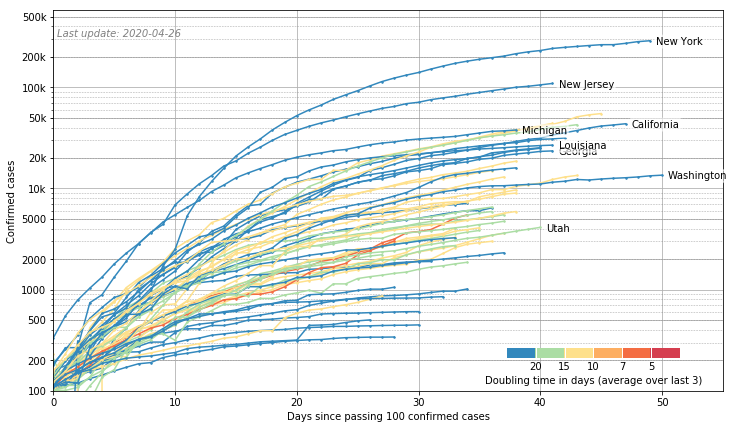

In [8]:
try_bool = df_state.groupby('State').max()['Delta C'] > 0
threshold_states = try_bool.index[try_bool].tolist()

notable_states = ['New York','New Jersey','Michigan',"California",
            'Washington','Louisiana','Georgia','Utah' ]

fig, ax = plt.subplots(1,1 ,figsize= full_w )  

xCmax = df_state['Delta C'].max()
yCmax = df_state['Confirmed'].max()

for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 

    # print(state) 
    # print(df_pl.tail() )

    doubling_category = df_pl['doubling'].iloc[0]

    pl1 = ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])

    y = df_pl['Confirmed'].iloc[-1]*0.98
    x = df_pl['Delta C'].iloc[-1] + 0.5      

    # print( x,y )

    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)

ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   

ax.yaxis.set_ticks( tick_list )
ax.yaxis.set_ticklabels( tick_label_list)

ax.set_xlim([0,xCmax+5])
ax.set_ylim([100,yCmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_cases) + " confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yCmax,5)*1.1], color=[.5,.5,.5], style='italic')

# cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels( bin_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')
 

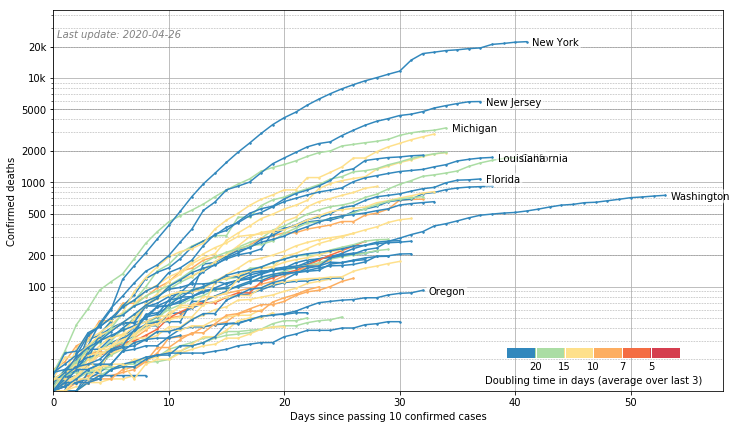

In [9]:
 
# plot states deaths--------------------------------------------
notable_states =   ['New York','New Jersey','Michigan',"California",'Washington','Louisiana',"Florida","Oregon"]

fig, ax = plt.subplots(1,1 ,figsize= full_w )  

xDmax = df_state['Delta D'].max()
yDmax = df_state['Deaths'].max()

for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 

    doubling_category = df_pl['doublingD'].iloc[0]
    pl1 = ax.plot( df_pl['Delta D' ],  df_pl['Deaths'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])

    y = df_pl['Deaths'].iloc[-1]*0.98
    x = df_pl['Delta D'].iloc[-1] + 0.5         

    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)

ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   

ax.yaxis.set_ticks( tick_list )
ax.yaxis.set_ticklabels( tick_label_list)

ax.set_xlim([0,xDmax+5])
ax.set_ylim([10,yDmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_deaths)+ " confirmed cases") 
ax.set_ylabel("Confirmed deaths") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yDmax,5)*1.1], color=[.5,.5,.5], style='italic')

xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels(bin_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')
  

Text(6, 120, 'Updated 2020-04-26')

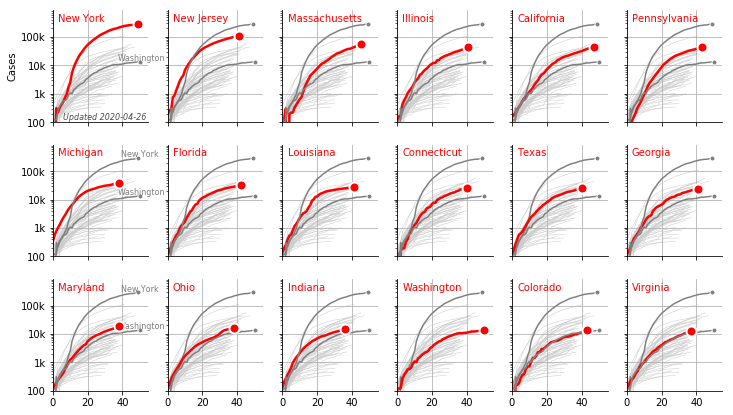

In [10]:

# ----------------plot grid of highlights-------------------------------------------------------
# sort states by confirmed cases on last date
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )     
sorted_names = sorted_states['State'].tolist()

notable_states = ['New York', 'Washington'  ]

dy = 3
dx = 6

fig, ax = plt.subplots( dy,dx ,figsize=full_w )

for i, (ax_1, goal_states) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])):  
    ax_1 = jp.plot_highlight(ax_1, goal_states, df_state['Delta C'],
                                            df_state['Confirmed'],
                                            df_state['State'],
                                            notable_states,
                                            threshold_cases)
    ax_1 .grid(True )   

    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_states):
                bool_state = df_state['State'] == state
                df_pl = df_state[bool_state] 

                y = df_pl['Confirmed'].iloc[-1]*1.1
                x = df_pl['Delta C'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])

    xCmax = df_state['Delta C'].max() 
    yCmax = df_state['Confirmed'].max()

    ax_1.set_xlim([0,xCmax+5])
    ax_1.set_ylim([100,yCmax*3])

ax[0,0].set_ylabel('Cases') 
ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [6, 120], color=[.3,.3,.3], style='italic',fontsize=8)

 

Text(6, 12, 'Updated 2020-04-26')

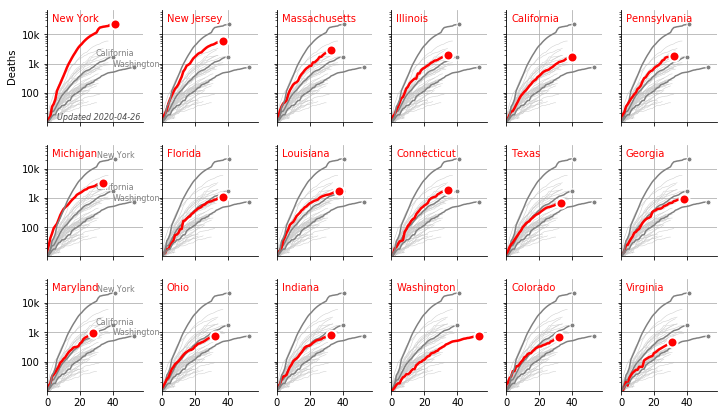

In [11]:
 
notable_states = ['New York' ,'Washington', 'California' ]

dy = 3
dx = 6

fig, ax = plt.subplots( dy,dx ,figsize=full_w )

for i, (ax_1, goal_states) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])):  
    ax_1 = jp.plot_highlight(ax_1, goal_states, df_state['Delta D'],
                                            df_state['Deaths'],
                                            df_state['State'],
                                            notable_states,
                                            threshold_deaths)
    ax_1 .grid(True )   

    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_states):
                bool_state = df_state['State'] == state
                df_pl = df_state[bool_state] 

                y = df_pl['Deaths'].iloc[-1]*1.1
                x = df_pl['Delta D'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])

    xCmax = df_state['Delta D'].max() 
    yCmax = df_state['Deaths'].max()

    ax_1.set_xlim([0,xCmax+5])
    ax_1.set_ylim([10,yCmax*3])


ax[0,0].set_ylabel('Deaths') 
ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [6, 12 ], color=[.3,.3,.3], style='italic',fontsize=8)


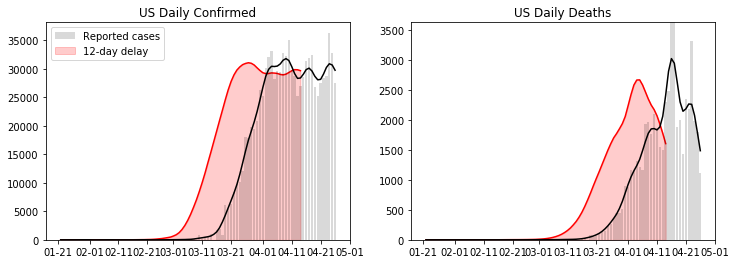

In [12]:
# # plot daily for US, by state data-----------------------------
df_pl = df_state.groupby( 'Date').sum() 
df_pl['Date'] = df_pl.index  

fig, ax = plt.subplots(1 ,2,figsize=(full_w[0] ,4))

ax[0] = jp.plot_daily( ax[0] , df_pl['Date'], df_pl['Daily Confirmed'] )
ax[1] = jp.plot_daily( ax[1] , df_pl['Date'], df_pl['Daily Deaths'] )

ax[0].set_title('US Daily Confirmed')
ax[1].set_title('US Daily Deaths')  
ax[0].legend( ax[0].get_legend_handles_labels()[0][::-1] , ax[0].get_legend_handles_labels()[1] [::-1])




Text(2020-01-22, 9604.56, 'Updated 2020-04-26')

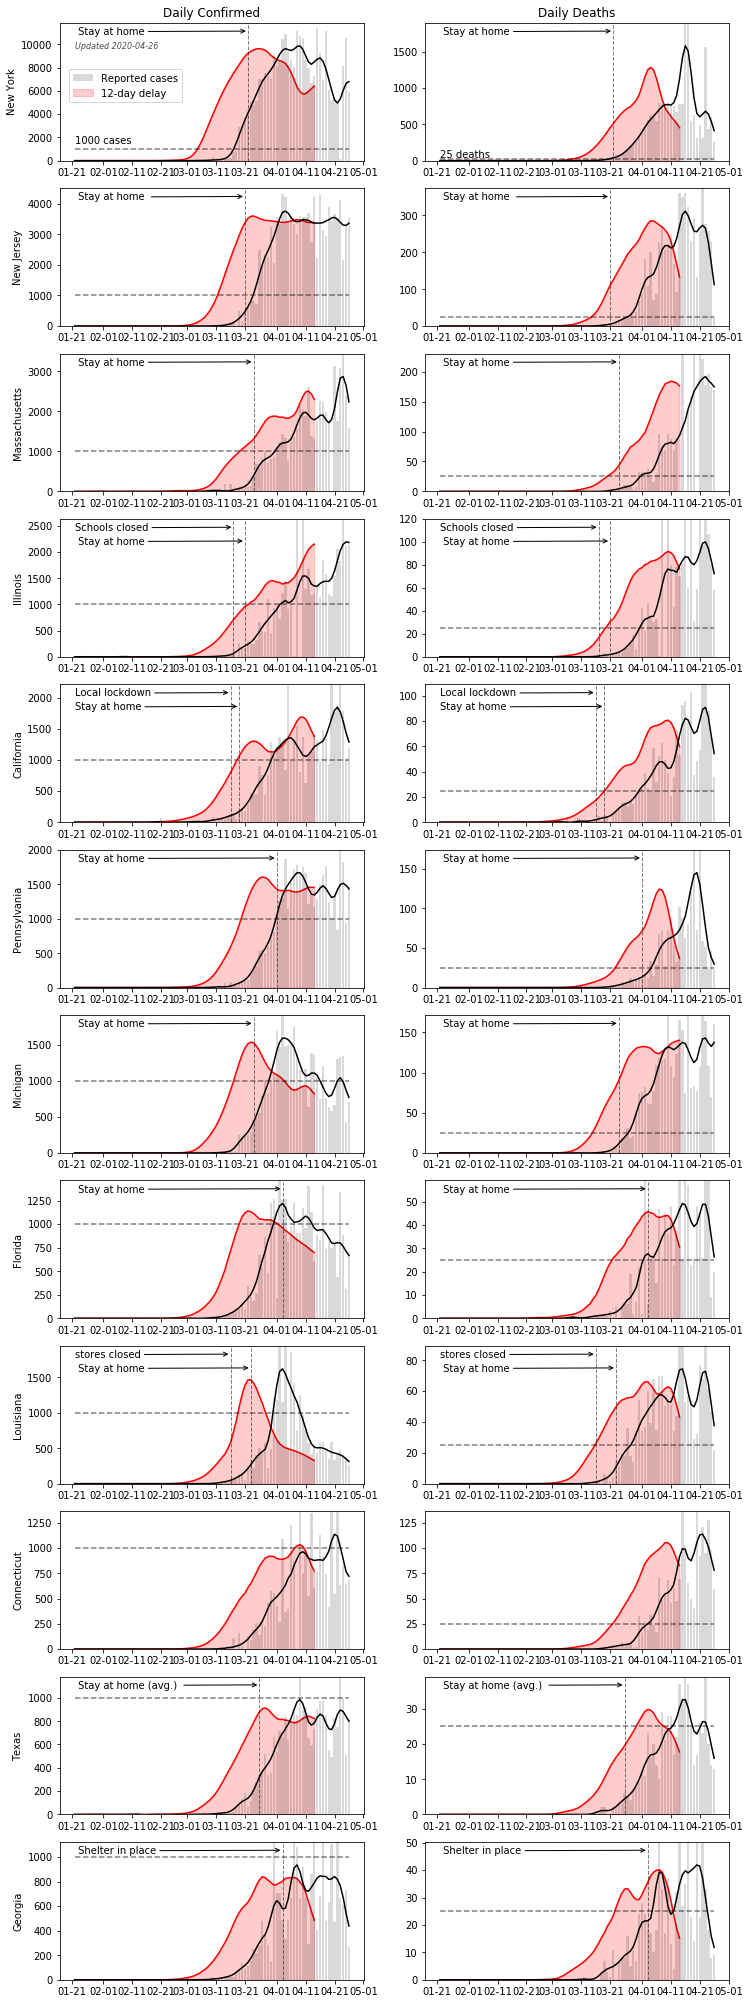

In [13]:
 # plot daily per state
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_states.head(5)  

n_state = 12
top_state = sorted_states['State'][:n_state].tolist()

dates = df_pl['Date' ].unique() 
fig, ax = plt.subplots(n_state ,2,figsize=( full_w[0] ,n_state*3))

n_correction = 1

for i,country in enumerate( top_state ):
    df_pl = df_state[ df_state['State'] == country]

    bool_measure = df_pl['Measure'].notnull() 
    measures= df_pl.loc[bool_measure,['Measure','Date']] 

    jp.plot_daily( ax[i,0] , df_pl['Date'], df_pl['Daily Confirmed'], measures)
    jp.plot_daily( ax[i,1] , df_pl['Date'], df_pl['Daily Deaths'],measures)

    # add comparison lines  
    ax[i,0].plot( dates[[0,len(dates)-1]], [1000,1000],'--',color='k', alpha = 0.5 )
    ax[i,1].plot( dates[[0,len(dates)-1]], [25,25],'--',color='k', alpha = 0.5 ) 
    ax[i,0].set_ylabel( country )

ax[0,0].set_title('Daily Confirmed')
ax[0,1].set_title('Daily Deaths') 

ax[0,0].legend(  ax[0,0].get_legend_handles_labels()[0][::-1] , 
               ax[0,0].get_legend_handles_labels()[1] [::-1],
               bbox_to_anchor=(0.42, .7))

ax[0,0].annotate('1000 cases',[dates[0],1000*1.5])
ax[0,1].annotate('25 deaths',[dates[0],25*1.5])

ax[0,0].annotate('Updated '+str(   dates[-1]  ), 
            [dates[0], df_state['Daily Confirmed'].max()*(0.94-0.1)], 
                color=[.3,.3,.3], style='italic',fontsize=8)
 